
## Loading the dependencies

In [1]:
import cv2 as cv
import numpy as np
import svg_points as svg
import matplotlib.pyplot as plt
import math
import time
import json

## Declaring global constants

In [2]:
# Paths
OBJ_ID         = "obj01" 
OBJ_CONFIG     = json.load(open(f"../config/{OBJ_ID}.json"))
OBJ_VIDEO_PATH = f"../data/{OBJ_ID}.mp4" 
OBJ_MASK_PATH  = f"../processed/{OBJ_ID}/masks.npy"
PLY_NOCOL_PATH = f"../processed/{OBJ_ID}/no_col.ply"
PLY_WTCOL_PATH = f"../processed/{OBJ_ID}/wt_col.ply"     

CAM_INTRINSIC_PATH  = "../processed/K.npy"
CAM_DISTORTION_PATH = "../processed/dist.npy"

# Region of interest for marker analysis
MARKER_ROI_LEFT_COL  = 1100
MARKER_ROI_RIGHT_COL = 1600
MARKER_ROI_UPPER_ROW = 0
MARKER_ROI_LOWER_ROW = 1080

# Cup relative coordinates respect to ROI
CUP_ROI_LEFT_COL     = 0
CUP_ROI_RIGHT_COL    = 300
CUP_ROI_UPPER_ROW    = 350
CUP_ROI_LOWER_ROW    = 730

 
# Standard sharpening kernel
SHARPENING_KERNEL    = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])
# Thresholding lower bound
THRESH_LOWER_BOUND   = 172

# 
LABEL_THRESH_POLY_DP = 0.0125
LABEL_MIN_AREA       = 1500
LABEL_SUBPIX_TERM    = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 50, 0.001)
LABEL_SUBPIX_WINDOW  = (6,6)

# 
LABEL_WDOT_MIN_AREA  = 10

LK_WIN_SIZE          = (15, 15)
LK_MAX_LEVEL         = 2
LK_CRITERIA          = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)

# CARVING
VOXEL_SIZE           = 1

## Performing the analysis

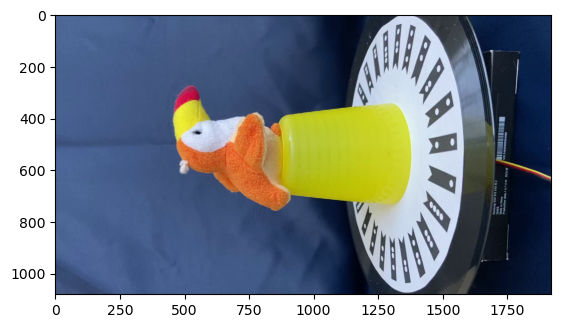

In [3]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)
    
assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

plt.imshow(rgb_frame)

### 1. ROI cutting

In order to make the marker detection easy and performant, we only focus on a defined portion of the image, called the Region of Intererest.

In [4]:
def roi_cut (frame):

    ROI = frame[MARKER_ROI_UPPER_ROW:MARKER_ROI_LOWER_ROW, MARKER_ROI_LEFT_COL:MARKER_ROI_RIGHT_COL]
   
    return ROI    

In [5]:
cloned = rgb_frame.copy()

ROI = roi_cut(cloned)

### 2. Intensity correction

In order to improve marker detection and pose estimate we sharpen the image. This will help thresholding but also corner detection

In [6]:
def intensity_correct (frame):
    sharpened = cv.filter2D(src=frame, ddepth=-1, kernel=SHARPENING_KERNEL)
    return sharpened

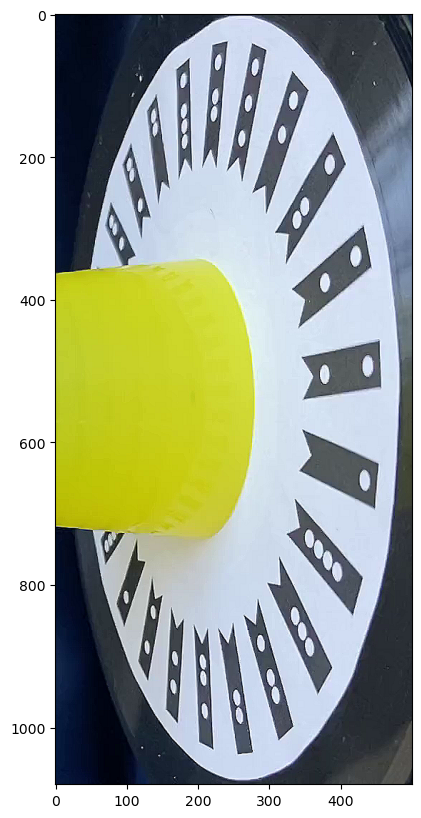

In [7]:
sharpened = intensity_correct(ROI)
plt.figure( figsize=(10,10))
plt.imshow(sharpened)

### 3. Thresholding

In order to find the shape of each marker label, we need to threshold the image to a black and white representation. Binary thresholding is enough for our purposes. We won't perform any analysis at the cup, so we can fill its bounding rectangle with white pixels (this will be useful for the contour detection process)

In [8]:
def threshold (frame):
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    ret, thresholded = cv.threshold(gray, 172, 255, cv.THRESH_BINARY)
    thresholded[CUP_ROI_UPPER_ROW:CUP_ROI_LOWER_ROW, CUP_ROI_LEFT_COL:CUP_ROI_RIGHT_COL] = 255 
    return thresholded

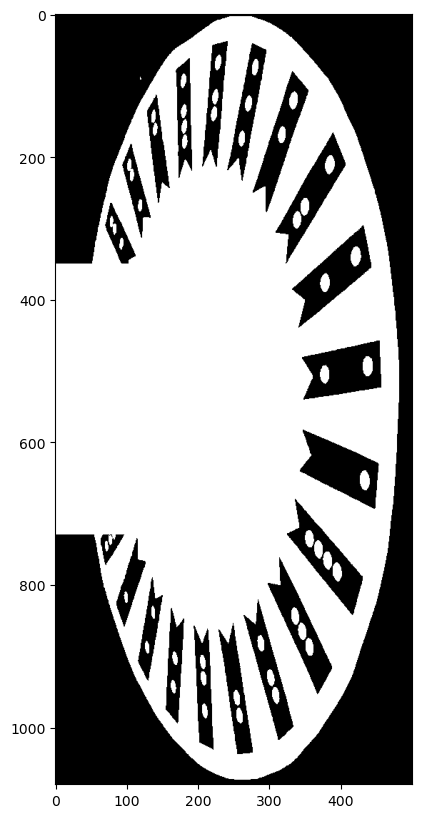

In [9]:
thresholded = threshold(ROI)

plt.figure( figsize=(10,10))
plt.imshow(thresholded, cmap = 'gray')

### 5. Detect markers

In [10]:
def get_markers (thresholded):
    contours, h = cv.findContours(thresholded, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    markers = []

    for i, cnt in enumerate(contours):
        p = h[0][i][3]
        if p != -1:
            approx_dp = cv.approxPolyDP(cnt, LABEL_THRESH_POLY_DP * cv.arcLength(cnt, True), True) 
            corners   = cv.cornerSubPix(thresholded, np.squeeze(approx_dp).astype('float32'), LABEL_SUBPIX_WINDOW, (-1,-1), LABEL_SUBPIX_TERM)
            area      = cv.contourArea(approx_dp)
            if area > LABEL_MIN_AREA and (len(approx_dp) == 5):
                markers.append(corners)
                
    return np.array(markers)

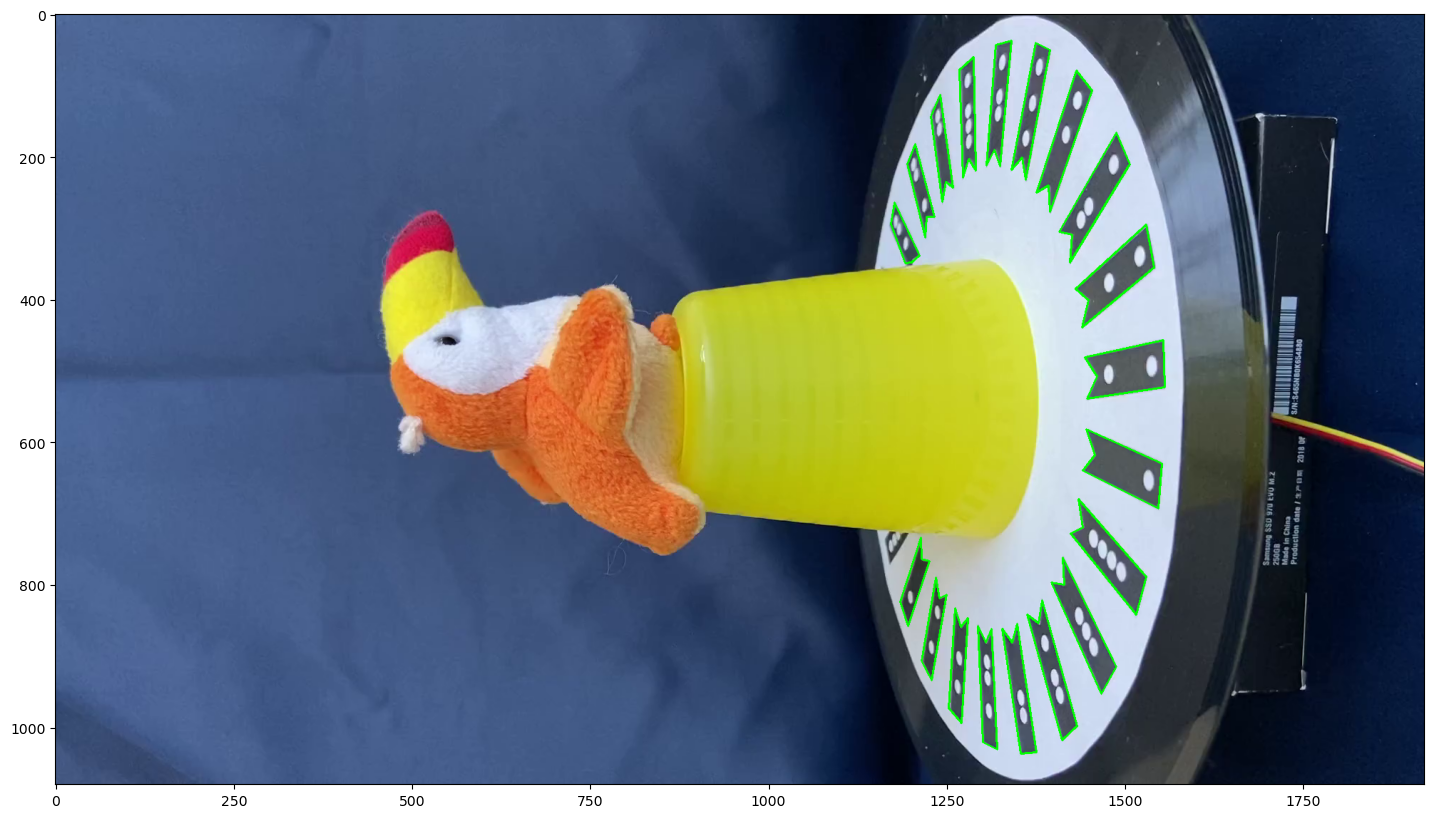

In [11]:
f = rgb_frame.copy()
markers = get_markers(thresholded)  
contoured = cv.drawContours(f,[marker.astype('int32') for marker in markers], -1, (0, 255, 0), 2, offset=(1100, 0))
        
plt.figure(figsize=(20,10) ) 
plt.imshow(contoured)

## 7. Detect marker points

In [12]:
def cart2pol(point):
    x, y = point
    rho  = np.sqrt(x**2 + y**2)
    phi  = math.degrees(np.arctan2(y, x))
    return(rho, phi)

def pol2cart(point):
    rho, phi = point
    x = rho * np.cos(math.radians(phi))
    y = rho * np.sin(math.radians(phi))
    return(x, y)

def sort_marker_points (center, points):
    
    shifted_pts = list(map(lambda pt: (pt[0] - center[0], pt[1] - center[1]), points))
    polar_pts   = list(map(cart2pol, shifted_pts))
        
    polar_pts    = np.array(polar_pts)
    polar_by_rho = polar_pts[polar_pts[:, 0].argsort()]
    
    internal_pts = np.array(polar_by_rho[:3])
    external_pts = np.array(polar_by_rho[3:])
    
    internal_by_phi = internal_pts[internal_pts[:, 1].argsort()]
    external_by_phi = external_pts[external_pts[:, 1].argsort()]
    
    A, B    = external_by_phi
    C, D, E = internal_by_phi[::-1]
    
    cart_pts      = list(map(pol2cart, [A, B, C, D, E]))
    unshifted_pts = list(map(lambda pt: (pt[0] + center[0], pt[1] + center[1]), cart_pts)) 
    
    return np.array(unshifted_pts)

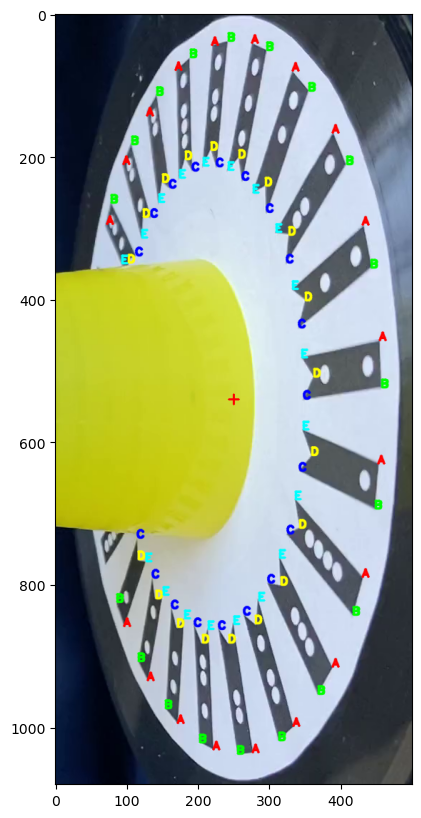

In [13]:
res = ROI.copy() 
CX, CY = ROI.shape[1] / 2, ROI.shape[0] / 2
letters = ['A', 'B', 'C', 'D', 'E']
colors  = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

cv.drawMarker(res, (int(CX), int(CY)), (255, 0, 0), cv.MARKER_CROSS, 15, 2)

for marker in markers:
    sorted_pts = sort_marker_points((CX, CY), marker)
    for i, pt in enumerate(sorted_pts):
        cv.putText(res, letters[i], pt.astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 2, cv.LINE_AA)
        
plt.figure(figsize=(10,10) ) 
plt.imshow(res)      

## 8. Detect marker value

In [14]:
def bin2dec (bin_str):
    return int(bin_str[::-1], 2)

def decode_marker(sorted_pts, thresholded):

    bin_str   = ""
    centroids = []
    
    c_x, c_y   = sorted_pts[3]    
    ext1, ext2 = sorted_pts[:2] 
    
    m_x = (ext1[0] + ext2[0]) / 2 
    m_y = (ext1[1] + ext2[1]) / 2
    
    delta_x = (m_x - c_x) / 6
    delta_y = (m_y - c_y) / 6

    
    for i in range(1, 6, 1):
        
        x = c_x + delta_x * i
        
        y = c_y + delta_y * i
  
        value = "0" if thresholded[int(y)][int(x)] == 255 else "1"
        
        bin_str += value
    
        centroids.append({
            "center": (int(x), int(y)),
            "value": value 
        })    
    
    
    return bin2dec(bin_str), centroids

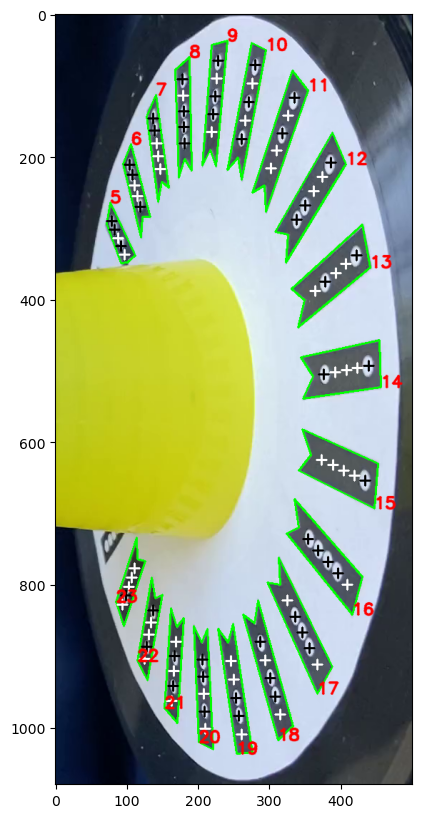

In [15]:
res = ROI.copy() 

for marker in markers:

    sorted_pts = sort_marker_points((CX, CY), marker)
    
    value, centroids = decode_marker(sorted_pts, thresholded)
    
    cv.drawContours(res, [marker.astype('int32')], -1, (0, 255, 0), 2)
    
    for c in centroids:
        cv.drawMarker(res, c["center"], (0, 0, 0) if c["value"] == "0" else (255, 255, 255), cv.MARKER_CROSS, 15, 2)
    
    cv.putText(res, str(value), sorted_pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    

plt.figure(figsize=(10,10) ) 
plt.imshow(res)  

## 9. Performance test

In [16]:
def marker_detect (frame, offset = (0,0)):
    
    roi     = roi_cut(frame)
    roi_ic  = intensity_correct(roi)
    roi_th  = threshold(roi_ic)
    
    markers = get_markers(roi_th)
    center  = (roi.shape[1] / 2, roi.shape[0] / 2)
    
    detected = []
    
    for marker in markers:
        sorted_pts = sort_marker_points (center, marker)
        value, centroids = decode_marker(sorted_pts, roi_th)
        
        offset_pts = []
        for pt in sorted_pts:
            x = pt[0] + offset[0]
            y = pt[1] + offset[1]
            offset_pts.append((x,y))
        
        offset_centroids = []
        for c in centroids:
            x, y = c["center"]
            x = x + offset[0]
            y = y + offset[1]
            offset_centroids.append({"center": (x, y), "value": c["value"]})
        
        detected.append((np.array(offset_pts), value, np.array(offset_centroids)))
        
    return roi, np.array(detected)

In [17]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)


while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    start         = time.time()
    roi, detected = marker_detect(frame, offset=(1100, 0))
    end           = time.time()
        
    for marker in detected:
    
        sorted_pts, value, centroids = marker
    
        cv.drawContours(frame, [sorted_pts.astype('int32')], -1, (0, 255, 0), 2)
    
        for c in centroids:
            cv.drawMarker(frame, c["center"], (0, 0, 0) if c["value"] == "0" else (255, 255, 255), cv.MARKER_CROSS, 15, 2)
    
        cv.putText(frame, str(value), sorted_pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    
    fps = int(1 / (end - start))
    
    cv.putText(frame, "FPS: " + str(fps), (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
    
    cv.imshow("frame", frame)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        

cap.release()
cv.destroyAllWindows()

/tmp/ipykernel_63066/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


### 10. Recover camera pose

In [18]:
def remove_same (arr):
    
    i = 0
    c = []
    
    while i < len(arr):
        pivot = arr[i]
        
        j = 1
        while (i + j < len(arr) and arr[i + j] == pivot):
            j += 1
        
        # Is the element unique? 
        if (j == 1):
            c.append(i)
        
        i += j
        
    return c


def remove_same_markers(sorted_markers):
    
    cleaned_markers = []
    cleaned_args    = remove_same(sorted_markers[:, 1])
    
    for arg in cleaned_args:
        cleaned_markers.append(sorted_markers[arg])
    
    return np.array(cleaned_markers)
    

In [19]:
def long_incr_seq (arr):
    
    cur_len = 1
    max_len = 1
    max_end = 0
    end     = 0
    
    for i, el in enumerate(arr[1:]):
        i = i + 1
        if (el == arr[i - 1] + 1):
            end = i
            cur_len = cur_len + 1
            
            max_end = end if cur_len > max_len else max_end
            max_len = cur_len if cur_len > max_len else max_len
            
        else:
            cur_len = 1
    
    return  max_end - (max_len - 1), max_end, max_len

def get_good_markers (sorted_markers):
    start, end, length = long_incr_seq(sorted_markers[:, 1])
    good_markers = sorted_markers[start:end + 1]
    return good_markers

In [20]:
K  = np.load(CAM_INTRINSIC_PATH)
dist_coeffs = np.load(CAM_DISTORTION_PATH)
svg_pts = svg.SVGPoints()


def pick_good_markers (markers):
    
    sorted_markers = markers[markers[:, 1].argsort()]

    # Remove duplicated detections
    cleaned_markers = remove_same_markers(sorted_markers)
    
    # Only keep markers which are likely to be correctly predicted
    good_markers    = get_good_markers(cleaned_markers)
    
    # The first and the last marker are likey to be more distorted
    good_markers    = good_markers[1:-1]
    
    if (len(good_markers) > 4):
        return True, good_markers
    else:
        return False, good_markers
    

def recover_camera_pose (markers):
    
    img_pts   = []
    ref_pts   = []
    
    for marker in markers:
            
        marker_img_pts, value, _ = marker
        marker_ref_pts           = svg_pts.get_reference_points(value)
            
        img_pts.append(marker_img_pts)
        ref_pts.append(marker_ref_pts)
            
    img_pts = np.array(img_pts).flatten().reshape((-1, 2))
    ref_pts = np.array(ref_pts).flatten().reshape((-1, 3))

    
    ok, Ri, Ti  = cv.solvePnP(ref_pts, img_pts, K, dist_coeffs, flags = cv.SOLVEPNP_IPPE)
    
    return Ri, Ti, ref_pts

/tmp/ipykernel_63066/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)


(array([0.05714286, 0.08571429, 0.14285714, 0.22857143, 0.22857143,
        0.11428571, 0.08571429, 0.02857143, 0.        , 0.02857143]),
 array([0.8401545 , 0.9236884 , 1.0072223 , 1.0907562 , 1.1742901 ,
        1.257824  , 1.3413579 , 1.42489181, 1.50842571, 1.59195961,
        1.67549351]),
 <BarContainer object of 10 artists>)

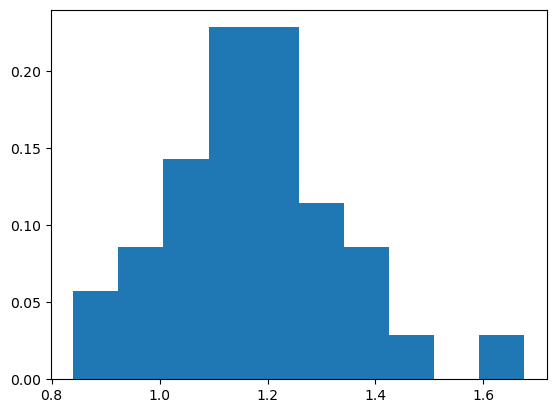

In [21]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

rmses = []
fpses = []
frames = 0

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    if (True):
        start             = time.time()
        roi, markers      = marker_detect(frame, offset=(1100, 0))
        det, good_markers = pick_good_markers(markers)
        
        if (det):
            Ri, Ti, ref_pts = recover_camera_pose(good_markers)
            end             = time.time()

            proj_pts, jacobian = cv.projectPoints(ref_pts, Ri, Ti, K, dist_coeffs)
            proj_pts = np.squeeze(proj_pts)

            points     = np.array([marker[0] for marker in good_markers]).reshape((-1, 2))
            points_hat = proj_pts
            
            for pt in proj_pts:
                cv.circle(frame, (int(pt[0]), int(pt[1])), 3, (0,0,255), -1)

            for marker in good_markers:
                pts, value, c = marker
                for pt in pts:
                    cv.circle(frame, (int(pt[0]), int(pt[1])), 3, (255,0,0), -1)
                cv.putText(frame, str(value), pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
            
            fps = int(1 / (end - start))
            rmse = math.sqrt(np.square(np.subtract(points, points_hat)).mean())
            
            rmses.append(rmse)
            fpses.append(fps)
            frames += 1
            
            cv.putText(frame, "FPS: " + str(fps), (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
            cv.putText(frame, "RMSE: " + str(round(rmse, 2)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
                
    cv.imshow("frame", frame)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

plt.hist(rmses, weights=np.ones_like(rmses) / len(rmses))

### 11. Projecting the voxel grid

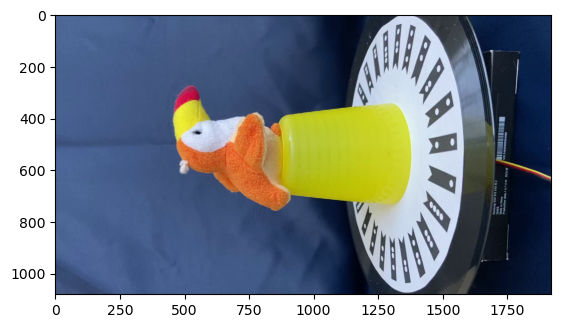

In [22]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)


plt.imshow(rgb_frame)

In [23]:
def build_voxel_grid (bp, grid_w, grid_h, grid_d, grid_res):
    
    voxel_grid = []
    
    offset_x = bp[0] - int(grid_w / 2)
    offset_y = bp[1] - int(grid_h / 2)
    offset_z = bp[2]
        
    x_acc = offset_x

    while x_acc < offset_x + grid_w:
        y_acc = offset_y
        while y_acc < offset_y + grid_h:
            z_acc = offset_z
            while z_acc < offset_z + grid_d:
                voxel_grid.append({
                    "coordinates": np.array([x_acc, y_acc, z_acc]),
                    "color": None
                    })
                z_acc += grid_res
            y_acc += grid_res
        x_acc += grid_res

    return np.array(voxel_grid)

In [24]:
def getProjectionMatrix (r_vec, t_vec, K):
    
    R, _ = cv.Rodrigues(r_vec)
    T    = t_vec
    
    extrinsic = np.zeros(shape=(3,4))
    extrinsic[:3, :3] = R
    extrinsic[:, 3:]  = T

    return K @ extrinsic

    
def from3Dto2D (pt, P):
    
    ptHom = np.append(pt, 1.0)
    
    pt2D  = P @ ptHom
    z     = pt2D[-1]
    pt2D  = pt2D / z
    
    return pt2D[:-1]

In [25]:
f = rgb_frame.copy()

roi, markers = marker_detect(f, offset=(1100, 0))
_, good_markers = pick_good_markers(markers)
r_vec, t_vec, ref_pts = recover_camera_pose(good_markers)

P = getProjectionMatrix(r_vec, t_vec, K)

voxel_grid = build_voxel_grid(
    OBJ_CONFIG["carving"]["voxelgrid_origin"], 
    OBJ_CONFIG["carving"]["voxelgrid_w"],
    OBJ_CONFIG["carving"]["voxelgrid_d"],
    OBJ_CONFIG["carving"]["voxelgrid_h"],
    VOXEL_SIZE
)

/tmp/ipykernel_63066/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)


10.616167306900024


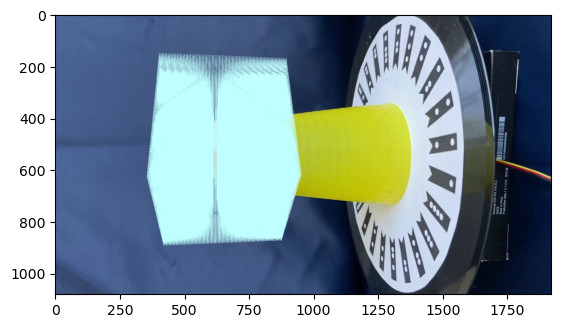

In [26]:
start = time.time()

for voxel in voxel_grid:
    proj_p = from3Dto2D(voxel["coordinates"], P)
    cv.circle(f, (int(proj_p[0]), int(proj_p[1])), 1, (192,255,255), -1)

delta = time.time() - start
    
plt.imshow(f)
print(delta)

2.2234840393066406


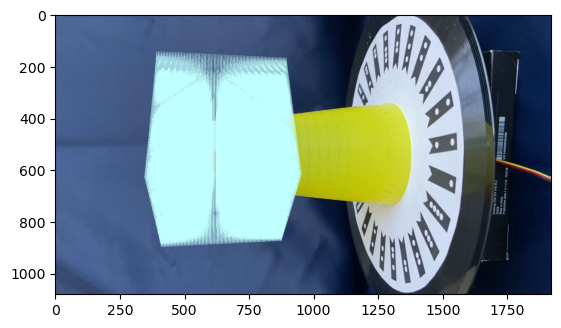

In [27]:
f = rgb_frame.copy() 

start = time.time()

voxels = np.array([v["coordinates"] for v in voxel_grid]).astype('float32')

projected, _ = cv.projectPoints(voxels, r_vec, t_vec, K, dist_coeffs)

for proj_p in np.squeeze(projected):
    cv.circle(f, (int(proj_p[0]), int(proj_p[1])), 1, (192,255,255), -1)

delta = time.time() - start
    
plt.imshow(f)
print(delta)

In [28]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

masks = iter(np.load(OBJ_MASK_PATH))

voxel_grid = build_voxel_grid(
    OBJ_CONFIG["carving"]["voxelgrid_origin"], 
    OBJ_CONFIG["carving"]["voxelgrid_w"],
    OBJ_CONFIG["carving"]["voxelgrid_d"],
    OBJ_CONFIG["carving"]["voxelgrid_h"],
    VOXEL_SIZE
)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    segmented = cv.bitwise_and(frame, frame, mask = next(masks))
    roi, markers      = marker_detect(frame, offset=(1100, 0))
    det, good_markers = pick_good_markers(markers)
        
    if (det):
        r_vec, t_vec, _ = recover_camera_pose(good_markers)    
        voxels       = np.array([v["coordinates"] for v in voxel_grid]).astype('float32')
        projected, _ = cv.projectPoints(voxels, r_vec, t_vec, K, dist_coeffs)
        bg_idxs      = []

        projected = np.squeeze(projected)

        for idx, proj_p in enumerate(projected):
            x, y = proj_p
            pixel = segmented[int(y), int(x)].copy()
                
            if not pixel.any():
                bg_idxs.append(idx)
                    
        voxel_grid = np.delete(voxel_grid, bg_idxs, axis = 0)
        projected  = np.delete(projected,  bg_idxs, axis = 0)

        for pt in projected:
            x, y = pt
            cv.circle(segmented, (int(x), int(y)), 1, (255,0,0), -1)
    
    cv.imshow('frame', segmented)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()

/tmp/ipykernel_63066/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)


In [29]:
def voxel_to_ply (center, size):
    
    x, y, z = center
    
    half = size / 2
    
    v = [0] * 8
    
    # Bottom face corners
    v[0] = (x - half, y - half, z - half)
    v[1] = (x - half, y + half, z - half)
    v[2] = (x + half, y + half, z - half)
    v[3] = (x + half, y - half, z - half)
    
    # Top face corners
    v[4] = (x - half, y - half, z + half)
    v[5] = (x - half, y + half, z + half)
    v[6] = (x + half, y + half, z + half)
    v[7] = (x + half, y - half, z + half)

    return v

def write_to_ply (path, voxel_grid, voxel_size, with_color = False):
    
    f      = open(path, "w")
    faces  = [0] * 6
    
    header = [
        "ply",
        "format ascii 1.0",
        f"element vertex {8 * len(voxel_grid)}", 
        "property float x",
        "property float y",
        "property float z",
    ]
    
    if (with_color):
        header.append("property uchar red",)
        header.append("property uchar green",)
        header.append("property uchar blue",)
    
    
    header.append(f"element face {6 * len(voxel_grid)}")
    header.append("property list uchar int vertex_index")
    header.append("end_header")

    
    # Vertical sides mask
    faces[0] = [0, 1, 4, 5]
    faces[1] = [1, 2, 5, 6]
    faces[2] = [2, 3, 6, 7]
    faces[3] = [3, 0, 7, 4]
    
    # Horizontal sides mask
    faces[4] = [0, 1, 2, 3]
    faces[5] = [4, 5, 6, 7]
    
    for header_line in header:
        f.write(f"{header_line}\n")
    
    for voxel in voxel_grid:
        vs = voxel_to_ply(voxel["coordinates"], voxel_size)
        for v in vs:
            vertex_def = f"{v[0]} {v[1]} {v[2]}"
            
            if with_color:
                r, g, b = voxel["color"]
                vertex_def += f" {r} {g} {b}"
            
            vertex_def += "\n"
            f.write(vertex_def)    
                
    for i in range(0, len(voxel_grid), 1):
        off = 8 * i
        for face in faces:
            f.write(f"4 {face[0] + off} {face[1] + off} {face[2] + off} {face[3] + off}\n")

    f.close()

In [30]:
write_to_ply(PLY_NOCOL_PATH, voxel_grid, VOXEL_SIZE)

In [31]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break

    roi, markers      = marker_detect(frame, offset=(1100, 0))
    det, good_markers = pick_good_markers(markers)
        
    if (det):
        z_buffer = {}
        
        r_vec, t_vec, _ = recover_camera_pose(good_markers)    
        voxels = np.array([v["coordinates"] for v in voxel_grid]).astype('float32')
        
        projected, _ = cv.projectPoints(voxels, r_vec, t_vec, K, dist_coeffs)
        projected = np.squeeze(projected)
        
        for i, proj in enumerate(projected):
            x, y = proj
            key  = f"{int(x)}-{int(y)}"
            depth = voxels[i][2]
            
            if key not in z_buffer or z_buffer[key][1] < depth:
                z_buffer[key] = (i, depth)
        
        for key in z_buffer:
            
            voxel_idx = z_buffer[key][0]  
            p_x, p_y  = [int(v) for v in key.split("-")]
            voxel = voxel_grid[voxel_idx]
            
            b, g, r = frame[p_y, p_x].copy()
            
            if voxel["color"] is None:
                voxel["color"] = (r, g, b)
            
            #cv.circle(frame, (p_x, p_y), 1, (255,0,0), -1) 
    
    cv.imshow('frame', frame)
        
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()

/tmp/ipykernel_63066/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)


In [32]:
write_to_ply(PLY_WTCOL_PATH, voxel_grid, VOXEL_SIZE, True)